## Lesson 07: Unsupervised Learning - continued

### Part 01: Comparing Different Clustering Algorithms


Last week, we used k-means clustering to the Enron financial dataset available in the [ud120-projects repo](https://www.github.com/udacity/ud120-projects). In today's lesson, we will work through a few other clustering algorithms and consider scenarios where one method is preferred over the others. The examples and code are drawn from the [sklearn documentation](http://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html)

We will look at the results of a few different clustering algorithms on "interesting" (or pathological) datasets with two independent variables. These examples will give us some intuition about which clustering algorithm might perform better in a given scenario. 

With this intuition, we will apply these techniques to the Enron dataset and compare our findings with the results of K-means clustering exercise we completed last week.


#### Preliminaries 
As usual, we start by loading the packages we are going to use. These should be already by installed in your environment. There are no new packages that need to be installed for this session

 - numpy
 - pandas
 - sklearn (this version of the notebook uses v0.18). 
 - matplotlib
 

 Run the cell below to load them

In [1]:
#!/usr/bin/python 

import pickle
import os, sys

try:
    import numpy as np
    print("Successfully imported numpy! (Version {})".format(np.version.version))
except ImportError:
    pass
    
try:
    import matplotlib
    import matplotlib.pyplot as plt
    print("Successfully imported matplotlib! (Version {})".format(matplotlib.__version__))
except ImportError:
    pass

try:
    import pandas as pd
    print("Successfully imported pandas! (Version {})".format(pd.__version__))
    pd.options.display.max_rows = 10
except ImportError:
    print("Could not import pandas!")

try:
    from IPython.display import display
    from IPython.display import Image
    print("Successfully imported display from IPython.display and Image!")
except ImportError:
    print("Could not import display from IPython.display")

%matplotlib inline

Successfully imported numpy! (Version 1.12.0b1)
Successfully imported matplotlib! (Version 1.5.1)
Successfully imported pandas! (Version 0.18.0)
Successfully imported display from IPython.display and Image!


In [2]:
# Adapted from ipython notebook from http://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html
import time

from sklearn import cluster, datasets
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.mixture import GaussianMixture
from scipy.cluster.hierarchy import dendrogram, linkage

np.random.seed(0)

# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

colors = np.array([x for x in 'bgrcmykbgrcmykbgrcmykbgrcmyk'])
colors = np.hstack([colors] * 20)

clustering_names = [
    'MiniBatchKMeans', 'AgglomerativeClustering',  'DBSCAN', 'GMM' ]


datasets = [noisy_circles, noisy_moons, blobs, no_structure];

The idea of clustering is to find entities (records, rows) that are most similar to each other and group them together. All clustering algorithms rely on some measure of "distance" to determine similarity (sometimes called a dissimilarity measure). Many algorithms, e.g., the k-Means algorthm we used last time, uses Euclidean distance. Most clusterers in `sklearn` have a parameter for defining this distance. 

Since the algorithm is sensitive to distance by design, it is very important that all features (variables) are normalized. In this section, we are using `StandardScaler` from `sklearn.preprocessing`. _Notice the difference between the results of `MinMaxSaler` and `StandardScaler`. Is one of them better to use in this context?_

In [3]:
# We'll just take one dataset and look at its statistics before and after scaling

X, y = blobs
XS = StandardScaler().fit_transform(X)
print "{:<15}  Min={:.3f}, Median={:.3f}, Average={:.3f}, Max={:.3f}".format('Raw values',np.min(X), np.median(X), np.mean(X), np.max(X))
print "{:<15}  Min={:.3f}, Median={:.3f}, Average={:.3f}, Max={:.3f}".format('StandardScaler', np.min(XS), np.median(XS), np.mean(XS), np.max(XS))
XS = MinMaxScaler().fit_transform(X)
print "{:<15}  Min={:.3f}, Median={:.3f}, Average={:.3f}, Max={:.3f}".format('MinMaxScaler', np.min(XS), np.median(XS), np.mean(XS), np.max(XS))


Raw values       Min=-13.590, Median=3.770, Average=1.646, Max=12.272
StandardScaler   Min=-1.822, Median=0.331, Average=-0.000, Max=1.535
MinMaxScaler     Min=0.000, Median=0.663, Average=0.566, Max=1.000


We have engineered four datasets:
- two concentric circles (circles)
- two partial moons (moons)
- three centers, two relatively close and the third well-separated (blobs)
- unstructured (no structure)
Each dataset has gaussian noise added to it -- hence the prefix "noisy" for the first three datasets.

We will find the 'best' cluster assignments assuming 2 clusters, using four different algorthms:
- k-Means
- hierarchical (Agglomerative) clustering
- [DBSCAN](https://en.wikipedia.org/wiki/DBSCAN) (Density-Based Spatial Clustering of Applications with Noise -- an algorithm not discussed in the lectures, but is well-researched and known to be fairly robust)
- Gaussian Mixture Model


c:\python27\lib\site-packages\sklearn\cluster\hierarchical.py:418: UserWarning: the number of connected components of the connectivity matrix is 2 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_components = _fix_connectivity(X, connectivity)
c:\python27\lib\site-packages\sklearn\cluster\hierarchical.py:418: UserWarning: the number of connected components of the connectivity matrix is 3 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_components = _fix_connectivity(X, connectivity)


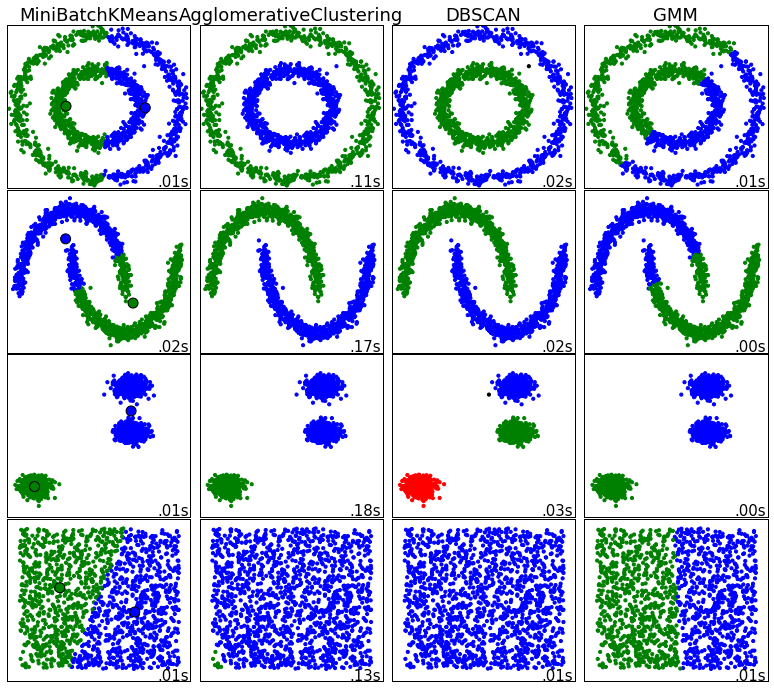

In [4]:
plt.figure(figsize=(len(clustering_names) * 2 + 3, 9.5));
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01);

plot_num = 1;

for i_dataset, dataset in enumerate(datasets):
    X, y = dataset
    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # connectivity matrix for Agglomerative clustering
    connectivity = kneighbors_graph(X, n_neighbors=10, include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)
    
    # create clustering estimators
    two_means = cluster.MiniBatchKMeans(n_clusters=2)
    dbscan = cluster.DBSCAN(eps=.2)
    gmm = GaussianMixture(n_components=2, tol=.2)
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average", affinity="cityblock", n_clusters=2,
        connectivity=connectivity)

    clustering_algorithms = [
        two_means,  average_linkage,  dbscan, gmm ]

    for name, algorithm in zip(clustering_names, clustering_algorithms):
        # predict cluster memberships
        t0 = time.time()
        algorithm.fit(X)
        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)

        # plot
        plt.subplot(4, len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)
        plt.scatter(X[:, 0], X[:, 1], color=colors[y_pred].tolist(), s=10)

        if hasattr(algorithm, 'cluster_centers_'):
            centers = algorithm.cluster_centers_
            center_colors = colors[:len(centers)]
            plt.scatter(centers[:, 0], centers[:, 1], s=100, c=center_colors)
        plt.xlim(-2, 2)
        plt.ylim(-2, 2)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1

plt.show()

** Please look over the results and write down why each algorithm came up with the answers it came up with (some of them are obviously wrong!) **

_** Answer **_:

### Hierarchical Clustering and dendrograms
In the video lectures on Single Link Clustering, Charles and Michael described how HACs are constructed. You also need to choose how to measure the distance between two points (or elements), a point and a cluster, as well as two clusters. _In the code block above, which two parameters are being used for calculating 'distance'?_

It is also interesting to visualize how these clusters are built up. The cell below plots a "dendrogram" (an entity with many levels of branching). A key point to remember is that every horizontal line identifying two clusters that get merged has its own height (difficult to see because of the scaling). Once the complete tree structure as been created, you can draw a horizontal line at an appropriate height to get an arbitrary number of clusters (of course can't have more than the number of leaves you started with!)

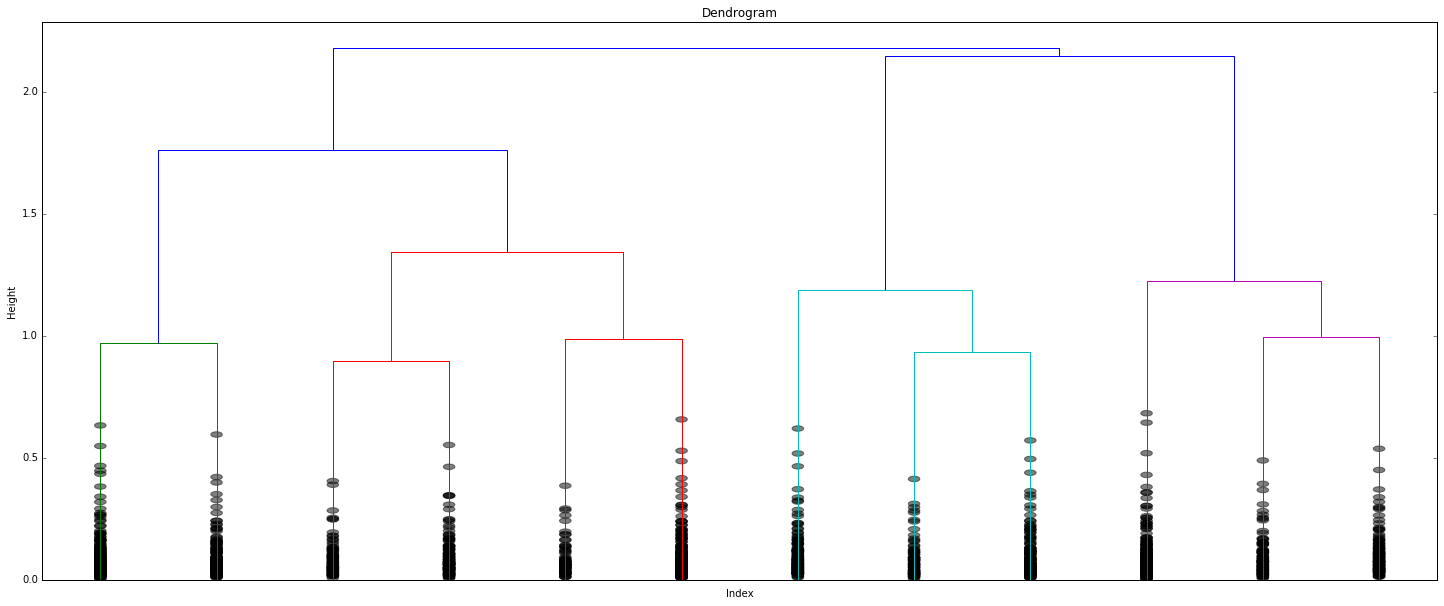

In [5]:
## https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/#Plotting-a-Dendrogram
#
# generate the linkage matrix
Z = linkage(X, 'average')
# calculate full dendrogram
plt.figure(figsize=(25, 10))
plt.title('Dendrogram')
plt.xlabel('Index')
plt.ylabel('Height')

dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=12,  # show only the last p merged clusters
    show_leaf_counts=False,  # otherwise numbers in brackets are counts
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)

plt.show()

### Gaussian Mixture Models and Expectation Maximization (EM)

The mixture model is inherently different from the other clustering algorithms we used in that  it determines a probability that any given case belongs to one of the _n_ clusters that it was supposed to find rather than a hard (0 or 1) assignment to a cluster. This can be very helpful when the clusters are overlapping.

Consider this simplified description of the mathematics behind _K_-means. We have a set of _N_ observations ($ x \epsilon \{1, ... , N\} $), and the algorithm is tasked with finding the best assignment of these points to the _K_ clusters (as well as finding the cluster centers). Let's introduce an indicator variable $ z_{i,j} $ that associates a point $ x_i $ with center $ k \varepsilon \{1,..,K\} $. $ z_{i,j} $ is zero for all combinations of $ i $ and $ j $ except when $ j = k $, where $k $ is the cluster to which $ x_i $ is assigned. The objective or cost function, $ J $ is the sum of squared distances (or mean squared distance if you want to scale it by the number of points) for this cluster assignment:

$$\large J = \Sigma_{i=1}^{N} \cdot \Sigma_{j=1}^K z_{i,j} \| x_i - \mu_k \|^2 $$

The _K_-means algorithm therefore needs to find values of  $ z_{i,j} $ and $ \mu_k $ that minimizes $ J $. There is closed form solution for this as the cost function is easily differentiable.

In a gaussian mixture model, the "points" in our dataset are assumed to be drawn from one or more i.i.d. (independent and identically distributed) random variables. The algorithm needs to be supplied the number of these i.i.d.s (i.e., the number of clusters); it then determines the probability that a given point belongs to each of the clusters it identifies. In words (the words of Charles and Michael), we assume:
- the data was generated by a underlying set of $ K $ i.i.d.s
- each i.i.d. is characterized by the Normal distribution, i.e., $\large \mathcal{N}( x | \mu_k, \sigma_k) $
- we don't know what the $ \mu_k $ and $ \sigma_k $ are (for simplicity we consider the $ \sigma $ the same for all i.i.d.s
- but we want to use our observations of each point $ x_n $ to deduce the the set $ \{ \mu_1, \mu_2, ... , \mu_K, \sigma \} $

We want to determine a set of $ \mu_k $ that maximizes the probability of observing the set of $ x_n $. However, unlike the _K_-means case, there isn't a closed form solution for solving this problem when there are more than one i.i.d involved. The Expectation Maximization algorithm achieves this goal by choosing some centers (randomly), calculating the resulting set of $ z_{i,j} $, i.e., cluster assignments, that maximizes the probabiity that the dataset was derived from this set of i.i.d.s. It then calculates the centers from these $ z_{i,j} $, iterating until the centers stop changing. 


### 3-D visualization and GMM for the iris dataset

The noisy blobs dataset we created and fit earlier was an example of three overlapping Gaussians in two dimensinal feature space. Looking back at those fits, you'll notice that GMM coalesced two of the clusters because the parameters forced it to do so. Lets now apply it in a higher dimensiona feature space. We will use the classic iris data set from the [UCI ML repository](http://mlearn.ics.uci.edu/MLRepository.html) for this part of the exercise. We don't have to go out and download thi dataset as it is already bundled into `sklearn`. 

Here is a description of the iris data set from [Wikipedia](https://en.wikipedia.org/wiki/Iris_flower_data_set)
>The Iris flower data set or Fisher's Iris data set is a multivariate data set introduced by Ronald Fisher in his 1936 paper The use of multiple measurements in taxonomic problems as an example of linear discriminant analysis. It is sometimes called Anderson's Iris data set because Edgar Anderson collected the data to quantify the morphologic variation of Iris flowers of three related species. Two of the three species were collected in the Gaspé Peninsula "all from the same pasture, and picked on the same day and measured at the same time by the same person with the same apparatus".

>The data set consists of 50 samples from each of three species of Iris (_Iris setosa_, _Iris virginica_ and _Iris versicolor_). Four features were measured from each sample: the length and the width of the sepals and petals, in centimetres. Based on the combination of these four features, Fisher developed a linear discriminant model to distinguish the species from each other.

** _As part of this exercise, we will also try an interactive 3D visualization. Unfortunately, the interactive part won't run in the notebook, so we will have to suspend the inline plot option temporarily_ **

Run the next cell to import the matplotlib toolkit for 3d plots and load the definition of our interactive plot function. 
The 3D plot should pop up only after you run the cell after the next one (one which pulls in the iris data and invokes Draw3D)

In [6]:
# Code source: Gaël Varoquaux
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause

# Modified for Udacity ConnectIntensive training
# Lutfur Khundkar


%matplotlib
from mpl_toolkits.mplot3d import Axes3D
#import matplotlib.animation as animation

def Draw3D(X,Y, labels=['X', 'Y', 'Z']):
    # To getter a better understanding of interaction of the dimensions
    # plot the first three PCA dimensions
    fig = plt.figure(1, figsize=(8, 6))
    ax = Axes3D(fig, elev=-150, azim=110)
    ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=Y, s=50.0,
               cmap='viridis')
    ax.set_title("Ineractive 3D plot")
    ax.set_xlabel(labels[0])
    ax.w_xaxis.set_ticklabels([])
    ax.set_ylabel(labels[1])
    ax.w_yaxis.set_ticklabels([])
    ax.set_zlabel(labels[2])
    ax.w_zaxis.set_ticklabels([])

    angle = 60.0
    ax.view_init(30, angle)
    plt.draw()
    plt.show()

Using matplotlib backend: TkAgg


In [7]:
from sklearn.decomposition import PCA

from sklearn import datasets
# import some data to play with
iris = datasets.load_iris()
X = iris.data[:, :2]  # we only take the first two features.
Y = iris.target

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5

X_reduced = PCA(n_components=3).fit_transform(iris.data)
Draw3D(X_reduced,Y,['PCA '+str(i+1) for i in range(3)])

#### In the next cell, use GMM to create 3 clusters from the iris dataset. Since we have the labels in Y, find the [`silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html)

####  Answer: 


In [14]:
# You will need to import the silhouette_score 
# sklearn.metrics.silhouette_score(X, labels, metric='euclidean', sample_size=None, random_state=None, **kwds)
from sklearn.metrics import silhouette_score

gmm_iris = GaussianMixture(n_components=3)
gmm_iris.fit(X_reduced)
y_pred = gmm_iris.predict(X_reduced)
Draw3D(X_reduced, y_pred)
score = silhouette_score(X_reduced, y_pred)

print "Silhouette Coefficient or 3 clusters is {:.3f}".format(score)


Silhouette Coefficient or 3 clusters is 0.515


That's the end of the basic exercise for this notebook. 

### Further Exploration

If you have time and want to pursue this a bit more, you can explore PCA and GMM on the enron data set we worked with last week. I have included a shortened version of that notebook in here.

In [ ]:
## TODO - adjust the value of the PATH_TO_MINI variable so it points to the top level folder of the Udacity projects
##     For example, here is the structure on my machine:
###         parent dir (projects)
###               -  ZKConnect (folder for ConnectIntensive notebooks
###                     - lesson-06-part-01,ipynb (this file)
###               -  projects  (root folder for all Udacity projects - github ud120) 
###                     - final_project
###                     - k_means
###                     - naive_bayes
###                     - tools
###
### So, I would set PATH_TO_MINI = '../projects'
###
### Once this is correctly set using either a relative path or an absolute path, the rest of the code should work correctly

PATH_TO_MINI = "../projects" # This may be different for each user

### Once you have the path set, the output from this cell should say so

try:
    path_ok = os.path.isfile(os.path.join(PATH_TO_MINI,"final_project","final_project_dataset.pkl"))
    if not path_ok:
        raise Exception("Path is not set correctly")
    print "PATH_TO_MINI appears correct (can open project data file)" 
except Exception as e:
    print e
    

In [ ]:
sys.path.append(PATH_TO_MINI)
sys.path.append(os.path.join(PATH_TO_MINI,"tools"))
sys.path.append(os.path.join(PATH_TO_MINI,"k_means"))

## Adapted from ud120-projects/k_means/k_means_cluster.py
from feature_format import featureFormat, targetFeatureSplit


#### Data Exploration and Cleaning

We'll skip the basic data exploration here today as we are familiar with the dataset. Howeve, we do need to remove the "TOTAL" key and impute the missing values (_NaN_) with 0. We will use `pandas` data frame to do the cleaning necessary. You can use the Draw3D function to getter a better visualization of the data

In [ ]:
### load in the dict of dicts containing all the data on each person in the dataset
data_dict = pickle.load( open(os.path.join(PATH_TO_MINI,"final_project","final_project_dataset.pkl"), "r"))
print "Loaded dataset - has {} keys (or rows)".format( len(data_dict.keys()) )

In [ ]:
# Remove "TOTAL" and replace missing values with 0.
KEYS_TO_REMOVE = ["TOTAL"]

for k in KEYS_TO_REMOVE:
    if data_dict.pop(k, 0):
        print "Removed item {} from data set".format(k)

print "Dataset with outliers removed has {} keys (or rows)".format( len(data_dict.keys()) )

# Create a DataFrame object from the Enron data dictionary
enron_df = pd.DataFrame.from_dict(data_dict)

# Take the transpose (.T) of the Enron DataFrame,
enron_df = enron_df.T

# Change all entries in the DataFrame with "NaN" to zeroes.
print "Replace all NaN's with 0"
enron_df[enron_df == "NaN"] = 0

# Now remove rows that are all zeros -- this was being done in the feature_format.py tool, we'll do it with pandas
orig_shape = enron_df.shape
enron_df[(enron_df !=0).any(axis=1)]
print "{} rows with all zeros were dropped".format('No' if orig_shape == enron_df.shape else str(orig.shape[0]-enron_df.shape[0]))


# List of columns, i.e. features
print "List of column labels:"
colnum = 4
colnames = [str(col) for col in enron_df.columns]
column_count = len(colnames)
blanks=[]*colnum
for i in xrange(0, column_count, colnum):
    fmt = "{:<28} "*colnum
    try:
        pp=colnames[i:min(i+colnum, column_count)]+blanks
        print fmt.format(*pp)
    except Exception as  e:
        pass


#### What are the features (i.e., columns or variables) available in this dataset? Which ones might be useful for identifying a poi? Select your top 5 choices and see if you there are combinations that seem to offer cleaner segments. You can use PCA and or GMM here to explore beyond the scope of the mini-project from last week.  

In [ ]:
colors = colors = np.where(enron_df.poi == 1, 'r', 'c')
features_select = ["salary", 'exercised_stock_options', 'long_term_incentive']
enron_data = np.array(enron_df[features_select])

## May want to scale and tranform the data
#enron_data_scaled = 
Draw3D(enron_data, colors, features_select)